# Text Subjectivity Classification - Fine-tuning a BERT model

In [61]:
# Libraries needed for data preparation
import pandas as pd
import numpy as np

datapath = "data/SUBJ/data.tsv"
df = pd.read_csv(datapath,  sep='\t')
df = df[["text", "label"]]

# Show the data
df.head()

,text,label
0,"smart and alert , thirteen conversations about...",1
1,"color , musical bounce and warm seas lapping o...",1
2,it is not a mass-market entertainment but an u...,1
3,a light-hearted french film about the spiritua...,1
4,my wife is an actress has its moments in looki...,1


In [62]:
print('Total number of data: {}'.format(len(df)))
print(40*'-')
print('Split by category:')
print(df["label"].value_counts())
print(40*'-')
nr_categories = len(df["label"].unique())
print("Number of categories: {n}".format(n=nr_categories))

Total number of data: 10000
----------------------------------------
Split by category:
label
1    5000
0    5000
Name: count, dtype: int64
----------------------------------------
Number of categories: 2


The label has to be converted to a number, an “index”. Let’s do that.

In [63]:
# Renaming, Input -> X, Output -> y
X = df['text']
y=np.unique(df['label'], return_inverse=True)[1]
print(type(X))

<class 'pandas.core.series.Series'>


In [64]:
import torch

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [65]:
BASE_MODEL_NAME = "bert-base-uncased"
FINE_TUNING = True

RANDOM_STATE = 42

TRAIN_BATCH_SIZE = 8
VAL_BATCH_SIZE = 8

EPOCHS = 30
if FINE_TUNING:
    SAVED_MODEL_NAME = 'models/bert-finetuned-' + str(EPOCHS) + '-epochs.sd'
else:
    SAVED_MODEL_NAME = 'models/our-bert-frozen.sd'

print(SAVED_MODEL_NAME)

models/bert-finetuned-30-epochs.sd


Let’s instantiate the BERT tokenizer.

In [66]:
from transformers import logging, AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)

Prepare the Dataset

In [67]:
# Convert data to torch tensor
X_list = X.to_list()
X_pt = tokenizer(X_list, padding='max_length', max_length = 256, truncation=True,  return_tensors='pt')["input_ids"]

y_list=y.tolist()
y_pt = torch.Tensor(y_list).long()

Let’s split the dataset into training, testing and validation data.

In [68]:
from sklearn.model_selection import train_test_split

X_pt_train, X_pt_test, y_pt_train, y_pt_test = train_test_split(X_pt, y_pt, test_size=0.1, random_state=RANDOM_STATE, stratify=y_pt)
X_pt_train, X_pt_val, y_pt_train, y_pt_val = train_test_split(X_pt_train, y_pt_train, test_size=0.1, random_state=RANDOM_STATE, stratify=y_pt_train)
print('#test_samples:', len(y_pt_test))
print('#train_samples:', len(y_pt_train))
print('#val_samples:', len(y_pt_val))

#test_samples: 1000
#train_samples: 8100
#val_samples: 900


We create a MyDataset class that will convert our data to torch dataset.

In [69]:
# Convert data to torch dataset
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X, y as Torch tensors
        """
        self.X_train = X
        self.y_train = y
        

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]


train_data_pt = MyDataset(X=X_pt_train, y=y_pt_train)
test_data_pt = MyDataset(X=X_pt_test, y=y_pt_test)
val_data_pt = MyDataset(X=X_pt_val, y=y_pt_val)

Create dataloaders, to prepare the dataset to be used for training and testing.

In [70]:
train_loader_pt = DataLoader(train_data_pt, batch_size=TRAIN_BATCH_SIZE)
test_loader_pt = DataLoader(test_data_pt, batch_size=TRAIN_BATCH_SIZE)
val_loader_pt = DataLoader(val_data_pt, batch_size=VAL_BATCH_SIZE)

**Build the Model**

Let’s build the model. For this we first need to get the BERT layer from the transformer library.

In [71]:
import transformers

dbert_pt = AutoModel.from_pretrained(BASE_MODEL_NAME)

In [73]:
from torch import nn
num_classes = 2

class BertClassification(nn.Module):
    def __init__(self):
        super(BertClassification, self).__init__()
        self.dbert = dbert_pt
        self.num_classes = 2
        self.linear = nn.Linear(dbert_pt.config.hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.5)
        # BERT model is trainable
        if FINE_TUNING:
            for param in dbert_pt.parameters():
                param.requires_grad_(True)
        else:
            for param in dbert_pt.parameters():
                param.requires_grad_(False)

    def forward(self, x):
        x = self.dbert(input_ids=x)
        x = x["last_hidden_state"][:,0,:]
        x = self.dropout(x)
        x = self.linear(x)
        return x

In [74]:
model_pt = BertClassification().to(device)

Number of parameters: trainable and non-trainable

In [75]:
total_params = sum(p.numel() for p in model_pt.parameters())
total_params_trainable = sum(p.numel() for p in model_pt.parameters() if p.requires_grad)
print("Number of parameters: ", total_params)
print("Number of trainable parameters: ", total_params_trainable)

Number of parameters:  109483778
Number of trainable parameters:  109483778


**Train the Model**

In [76]:
from datetime import datetime


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_pt.parameters(), lr=1e-5, weight_decay=0.01)
from tqdm import tqdm
# Define the dictionary "history" that will collect key performance indicators during training
history = {}
history["epoch"]=[]
history["train_loss"]=[]
history["valid_loss"]=[]
history["train_accuracy"]=[]
history["valid_accuracy"]=[]

# Measure time for training
start_time = datetime.now()

# Loop on epochs
for e in range(EPOCHS):
    
    # Set mode in train mode
    model_pt.train()
    
    train_loss = 0.0
    train_accuracy = []
    
    # Loop on batches
    for X, y in tqdm(train_loader_pt):
        X = X.to(device)
        y = y.to(device)
        # Get prediction & loss
        # print(X.is_cuda)
        # print(y.is_cuda)
        prediction = model_pt(X)
       
        loss = criterion(prediction, y)
        
        # Adjust the parameters of the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        prediction_index = prediction.argmax(axis=1)
        accuracy = (prediction_index==y)
        train_accuracy += accuracy
    
    train_accuracy = (sum(train_accuracy) / len(train_accuracy)).item()
    # Calculate the loss on the test data after each epoch
    # Set mode to evaluation (by opposition to training)
    model_pt.eval()
    valid_loss = 0.0
    valid_accuracy = []
    for X, y in val_loader_pt:
        X = X.to(device)
        y = y.to(device)  
        prediction = model_pt(X)
        loss = criterion(prediction, y)

        valid_loss += loss.item()
        
        prediction_index = prediction.argmax(axis=1)
        accuracy = (prediction_index==y)
        valid_accuracy += accuracy
    valid_accuracy = (sum(valid_accuracy) / len(valid_accuracy)).item()
    if (e + 1) % 5 == 0:
        temp_model_name = 'models/bert-finetuned-' + str(e + 1) + '-epochs.sd'
        torch.save(model_pt.state_dict(), temp_model_name)
        print("Model saved: ", temp_model_name)

    # Populate history
    history["epoch"].append(e+1)
    history["train_loss"].append(train_loss / len(train_loader_pt))
    history["valid_loss"].append(valid_loss / len(test_loader_pt))
    history["train_accuracy"].append(train_accuracy)
    history["valid_accuracy"].append(valid_accuracy)    
        
    print(f'Epoch {e+1} \t\t Training Loss: {train_loss / len(train_loader_pt) :10.3f} \t\t Validation Loss: {valid_loss / len(test_loader_pt) :10.3f}')
    print(f'\t\t Training Accuracy: {train_accuracy :10.3%} \t\t Validation Accuracy: {valid_accuracy :10.3%}')

# Measure time for training
end_time = datetime.now()
training_time_pt = (end_time - start_time).total_seconds()

100%|██████████| 1013/1013 [02:53<00:00,  5.84it/s]


Epoch 1 		 Training Loss:      0.174 		 Validation Loss:      0.136
		 Training Accuracy:    92.765% 		 Validation Accuracy:    96.111%


100%|██████████| 1013/1013 [02:51<00:00,  5.90it/s]


Epoch 2 		 Training Loss:      0.064 		 Validation Loss:      0.142
		 Training Accuracy:    97.765% 		 Validation Accuracy:    95.556%


100%|██████████| 1013/1013 [02:44<00:00,  6.14it/s]


Epoch 3 		 Training Loss:      0.025 		 Validation Loss:      0.180
		 Training Accuracy:    99.259% 		 Validation Accuracy:    95.667%


100%|██████████| 1013/1013 [02:44<00:00,  6.14it/s]


Epoch 4 		 Training Loss:      0.017 		 Validation Loss:      0.198
		 Training Accuracy:    99.469% 		 Validation Accuracy:    95.333%


100%|██████████| 1013/1013 [02:45<00:00,  6.12it/s]


Model saved:  models/bert-finetuned-5-epochs.sd
Epoch 5 		 Training Loss:      0.010 		 Validation Loss:      0.210
		 Training Accuracy:    99.691% 		 Validation Accuracy:    95.667%


100%|██████████| 1013/1013 [02:46<00:00,  6.07it/s]


Epoch 6 		 Training Loss:      0.014 		 Validation Loss:      0.192
		 Training Accuracy:    99.593% 		 Validation Accuracy:    96.111%


100%|██████████| 1013/1013 [02:55<00:00,  5.78it/s]


Epoch 7 		 Training Loss:      0.005 		 Validation Loss:      0.244
		 Training Accuracy:    99.840% 		 Validation Accuracy:    95.444%


100%|██████████| 1013/1013 [02:52<00:00,  5.86it/s]


Epoch 8 		 Training Loss:      0.009 		 Validation Loss:      0.181
		 Training Accuracy:    99.605% 		 Validation Accuracy:    96.444%


100%|██████████| 1013/1013 [02:52<00:00,  5.86it/s]


Epoch 9 		 Training Loss:      0.001 		 Validation Loss:      0.232
		 Training Accuracy:    99.975% 		 Validation Accuracy:    96.000%


100%|██████████| 1013/1013 [02:54<00:00,  5.82it/s]


Model saved:  models/bert-finetuned-10-epochs.sd
Epoch 10 		 Training Loss:      0.008 		 Validation Loss:      0.242
		 Training Accuracy:    99.765% 		 Validation Accuracy:    95.444%


100%|██████████| 1013/1013 [02:53<00:00,  5.85it/s]


Epoch 11 		 Training Loss:      0.004 		 Validation Loss:      0.211
		 Training Accuracy:    99.877% 		 Validation Accuracy:    96.556%


100%|██████████| 1013/1013 [02:53<00:00,  5.85it/s]


Epoch 12 		 Training Loss:      0.001 		 Validation Loss:      0.246
		 Training Accuracy:    99.975% 		 Validation Accuracy:    96.000%


100%|██████████| 1013/1013 [02:52<00:00,  5.86it/s]


Epoch 13 		 Training Loss:      0.005 		 Validation Loss:      0.221
		 Training Accuracy:    99.815% 		 Validation Accuracy:    96.111%


100%|██████████| 1013/1013 [02:53<00:00,  5.85it/s]


Epoch 14 		 Training Loss:      0.006 		 Validation Loss:      0.245
		 Training Accuracy:    99.864% 		 Validation Accuracy:    95.778%


100%|██████████| 1013/1013 [02:53<00:00,  5.83it/s]


Model saved:  models/bert-finetuned-15-epochs.sd
Epoch 15 		 Training Loss:      0.005 		 Validation Loss:      0.206
		 Training Accuracy:    99.840% 		 Validation Accuracy:    96.333%


100%|██████████| 1013/1013 [02:54<00:00,  5.82it/s]


Epoch 16 		 Training Loss:      0.003 		 Validation Loss:      0.261
		 Training Accuracy:    99.889% 		 Validation Accuracy:    95.556%


100%|██████████| 1013/1013 [02:52<00:00,  5.89it/s]


Epoch 17 		 Training Loss:      0.003 		 Validation Loss:      0.232
		 Training Accuracy:    99.938% 		 Validation Accuracy:    96.000%


100%|██████████| 1013/1013 [02:54<00:00,  5.81it/s]


Epoch 18 		 Training Loss:      0.002 		 Validation Loss:      0.246
		 Training Accuracy:    99.963% 		 Validation Accuracy:    95.333%


100%|██████████| 1013/1013 [02:52<00:00,  5.86it/s]


Epoch 19 		 Training Loss:      0.006 		 Validation Loss:      0.189
		 Training Accuracy:    99.815% 		 Validation Accuracy:    96.667%


100%|██████████| 1013/1013 [02:52<00:00,  5.87it/s]


Model saved:  models/bert-finetuned-20-epochs.sd
Epoch 20 		 Training Loss:      0.000 		 Validation Loss:      0.220
		 Training Accuracy:    99.988% 		 Validation Accuracy:    96.889%


100%|██████████| 1013/1013 [02:51<00:00,  5.89it/s]


Epoch 21 		 Training Loss:      0.004 		 Validation Loss:      0.224
		 Training Accuracy:    99.926% 		 Validation Accuracy:    95.889%


100%|██████████| 1013/1013 [02:54<00:00,  5.80it/s]


Epoch 22 		 Training Loss:      0.000 		 Validation Loss:      0.237
		 Training Accuracy:   100.000% 		 Validation Accuracy:    96.111%


100%|██████████| 1013/1013 [02:48<00:00,  6.02it/s]


Epoch 23 		 Training Loss:      0.000 		 Validation Loss:      0.258
		 Training Accuracy:   100.000% 		 Validation Accuracy:    96.111%


100%|██████████| 1013/1013 [02:45<00:00,  6.12it/s]


Epoch 24 		 Training Loss:      0.000 		 Validation Loss:      0.264
		 Training Accuracy:   100.000% 		 Validation Accuracy:    96.111%


100%|██████████| 1013/1013 [02:47<00:00,  6.06it/s]


Model saved:  models/bert-finetuned-25-epochs.sd
Epoch 25 		 Training Loss:      0.000 		 Validation Loss:      0.274
		 Training Accuracy:   100.000% 		 Validation Accuracy:    96.222%


100%|██████████| 1013/1013 [02:45<00:00,  6.12it/s]


Epoch 26 		 Training Loss:      0.009 		 Validation Loss:      0.220
		 Training Accuracy:    99.802% 		 Validation Accuracy:    95.444%


100%|██████████| 1013/1013 [02:45<00:00,  6.12it/s]


Epoch 27 		 Training Loss:      0.001 		 Validation Loss:      0.233
		 Training Accuracy:    99.938% 		 Validation Accuracy:    96.556%


100%|██████████| 1013/1013 [02:45<00:00,  6.13it/s]


Epoch 28 		 Training Loss:      0.001 		 Validation Loss:      0.249
		 Training Accuracy:    99.975% 		 Validation Accuracy:    96.333%


100%|██████████| 1013/1013 [02:45<00:00,  6.13it/s]


Epoch 29 		 Training Loss:      0.000 		 Validation Loss:      0.265
		 Training Accuracy:   100.000% 		 Validation Accuracy:    96.556%


100%|██████████| 1013/1013 [02:45<00:00,  6.13it/s]


Model saved:  models/bert-finetuned-30-epochs.sd
Epoch 30 		 Training Loss:      0.004 		 Validation Loss:      0.266
		 Training Accuracy:    99.951% 		 Validation Accuracy:    96.222%


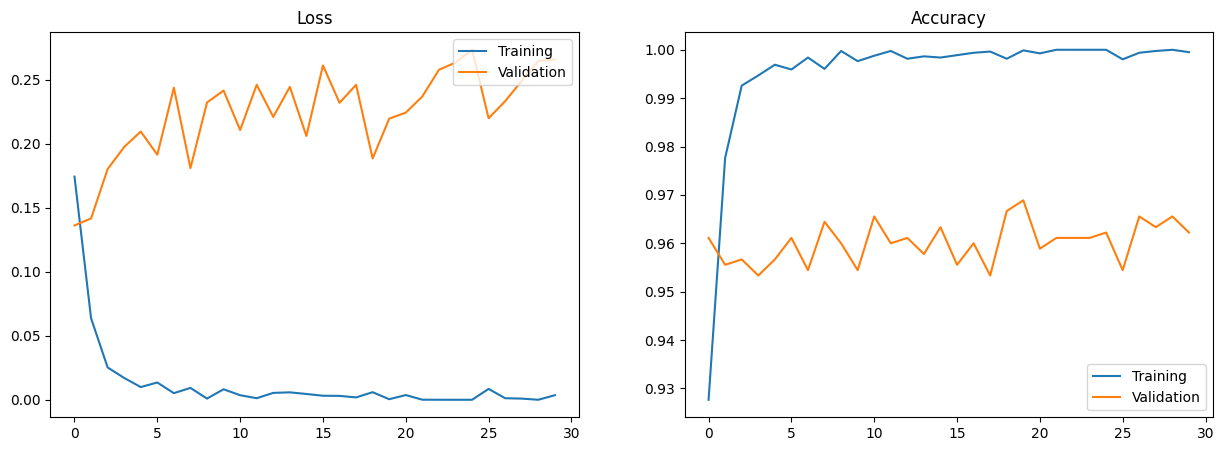

In [77]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history['train_loss'], label='Training')
ax[0].plot(history['valid_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history['train_accuracy'], label='Training')
ax[1].plot(history['valid_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

**Save the Model**

In [80]:
# Save model
torch.save(model_pt.state_dict(), SAVED_MODEL_NAME)

# References

Building a Text Classification in PyTorch
SOURCE: https://medium.com/@claude.feldges/text-classification-with-bert-in-tensorflow-and-pytorch-4e43e79673b3

Modified using Model contrastive learning repo:
https://github.com/hiyouga/Dual-Contrastive-Learning/tree/main
